In [27]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import zipfile
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [28]:
#Jens/Yassin's resize function
def resize_with_pad(imgpath, df):
    desired_size = 256
    images = list(df['ogfilename'])
    resized = []
    for i in tqdm(images):
        img = imread(imgpath + i)
#         Remove unnecessary details from images
        if len(img.shape) > 2:
            img = img[:, :, 0]
#         Determine which side is bigger and therefore used as initial resize
        if img.shape[0] >= img.shape[1]:
            scale_percent = (desired_size/ img.shape[0])
        else:
            scale_percent = (desired_size/ img.shape[1])
#             Resize
        width = int(img.shape[1] * scale_percent)
        height = int(img.shape[0] * scale_percent)
        dim = (width, height)
        resize = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
#         Determine how much border should be added
        delta_w = desired_size - width
        delta_h = desired_size - height
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
#         Color of border
        color = [0, 0, 0]
        new_im = cv2.copyMakeBorder(resize, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
        resized.append(new_im)
    return resized

In [29]:
#Vectorised version of an lbp calculator which allows an entire image to be coverted, instead of pixel by pixel
def lbp_calculated_pixel_vec(img):
    #Get center pixel value
    center = img[1:-1,1:-1]
    #Create an array to stor lbp values
    lbp_val = np.zeros_like(center)
    #Compare the center value to its neighbours. The lbp_val array is then filled with binary numbers depending on the comparison
    lbp_val[:,:] = img[0:-2,0:-2] > center
    lbp_val[:,:] |= (img[0:-2,1:-1] > center)<<np.uint8(1)
    lbp_val[:,:] |= (img[0:-2,2:] > center)<<np.uint8(2)
    lbp_val[:,:] |= (img[1:-1,2:] > center)<<np.uint8(3)
    lbp_val[:,:] |= (img[2:,2:] > center)<<np.uint(4)
    lbp_val[:,:] |= (img[2:,1:-1] > center)<<np.uint(5)
    lbp_val[:,:] |= (img[2:,0:-2] > center)<<np.uint(6)
    lbp_val[:,:] |= (img[1:-1,0:-2] > center)<<np.uint(7)
    return lbp_val

In [30]:
#Just for dataset if needed
#!darwin dataset pull v7-labs/covid-19-chest-x-ray-dataset:all-images


In [31]:
#Same method as NN-test file from Jens to get the data loaded
ziploc ="/Users/lennardbornemann/PatternRec/groupProj/"
imgLoc = "/Users/lennardbornemann/.darwin/datasets/v7-labs/covid-19-chest-x-ray-dataset/images/"
zf= zipfile.ZipFile(ziploc+'clean_data.zip') 
df = pd.read_csv(zf.open('clean_data.csv'))

In [32]:
#Resize all images using Jens/Yassin's resize function
data = np.asarray(resize_with_pad(imgLoc,  df))

100%|██████████| 6504/6504 [01:57<00:00, 55.43it/s] 


In [35]:
fungal_mask = (df['type'] == 'Fungal Pneumonia')
un_mask = (df['type'] == 'Undefined Pneumonia')
nan_mask = df['type'].isna()

# Get the index of rows with the specific condition
fungal_index = np.array(df.loc[fungal_mask].index)
un_index = np.array(df.loc[un_mask].index)
nan_index = np.array(df.loc[nan_mask].index)

rem_index = np.sort(np.concatenate((fungal_index,un_index,nan_index)))

df_clean = df.drop(rem_index)
data_clean = np.delete(data, rem_index, axis=0)


In [36]:
df_clean.loc[df_clean['Covid'] == True, 'type'] = 'Covid Viral Pneumonia'

In [39]:
#Convert the resized images to lbp versions
lbp_applied = []
for img in data_clean:
    img_lbp = lbp_calculated_pixel_vec(img)
    lbp_applied.append(img_lbp)

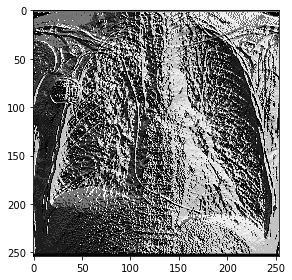

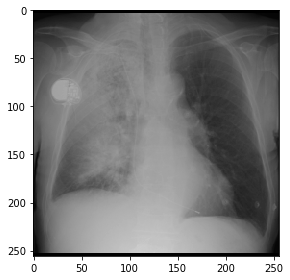

In [40]:
#Example visual comparison of the lbp version to the normal resized version of an image
imshow(lbp_applied[1])
plt.show()

imshow(data_clean[1])
plt.show()

In [41]:
lbp_applied = np.array(lbp_applied)
#Create individual lbp histograms of each image
individual_histograms = []
for i in range(lbp_applied.shape[0]):
    hist = np.histogram(lbp_applied[i], bins=256, range=(0, 255))[0]
    individual_histograms.append(hist)

In [42]:
normalized_histograms = []

for hist in individual_histograms:
    # Normalize the histogram by dividing each bin by the total number of pixels in the image
    normalized_hist = hist / np.sum(hist)
    normalized_histograms.append(normalized_hist)

In [43]:
#Split the normalized histograms into train and testing sets, labelled according to the label of the original data
#ONLY DISTINGUISH BETWEEN COVID NONCOVID BELOW
X_train_cov, X_test_cov, y_train_cov, y_test_cov = train_test_split(normalized_histograms, df_clean["Covid"], test_size=0.2)

In [44]:
#Create and fit the SVM
svmModel = svm.SVC()
svmModel.fit(X_train_cov, y_train_cov)
svmPredictions = svmModel.predict(X_test_cov)

In [45]:
score = svmModel.score(X_test_cov, y_test_cov)
print("Accuracy:", score)

Accuracy: 0.9319781078967944


In [46]:
parameters = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
grid_cov = GridSearchCV(svm.SVC(),parameters,refit=True,verbose=0)
grid_cov.fit(X_train_cov,y_train_cov)

grid_cov_predictions = grid_cov.predict(X_test_cov)

In [47]:
gscore = grid_cov.score(X_test_cov, y_test_cov)
print("Accuracy:", gscore)
# print classification report
print(classification_report(y_test_cov, grid_cov_predictions))

Accuracy: 0.9585613760750586
              precision    recall  f1-score   support

       False       0.97      0.99      0.98      1179
        True       0.80      0.63      0.70       100

    accuracy                           0.96      1279
   macro avg       0.88      0.81      0.84      1279
weighted avg       0.96      0.96      0.96      1279



In [48]:
#MULTICLASS SVM BELOW
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(normalized_histograms, df_clean["type"], test_size=0.2)

In [49]:
#Create and fit the SVM
svmModel = svm.SVC()
svmModel.fit(X_train_multi, y_train_multi)
svmPredictions = svmModel.predict(X_test_multi)

In [50]:
score = svmModel.score(X_test_multi, y_test_multi)
print("Accuracy:", score)

Accuracy: 0.6356528537920251


In [51]:
parameters = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
grid_multi = GridSearchCV(svm.SVC(),parameters,refit=True,verbose=0)
grid_multi.fit(X_train_multi,y_train_multi)

grid_multi_predictions = grid_multi.predict(X_test_multi)

In [52]:
gscore = grid_multi.score(X_test_multi, y_test_multi)
print("Accuracy:", gscore)
# print classification report
print(classification_report(y_test_multi, grid_multi_predictions))

Accuracy: 0.7591868647380766
                       precision    recall  f1-score   support

  Bacterial Pneumonia       0.74      0.86      0.80       576
Covid Viral Pneumonia       0.84      0.73      0.78       110
         No Pneumonia       0.82      0.89      0.86       314
      Viral Pneumonia       0.66      0.42      0.51       279

             accuracy                           0.76      1279
            macro avg       0.77      0.72      0.74      1279
         weighted avg       0.75      0.76      0.75      1279



In [58]:
#BELOW IS FOR AUGMENTED DATA WITH FINAL_TRAIN AND FINAL_VAL CSV
trainImgLoc = "/Users/lennardbornemann/PatternRec/groupProj/train/"
valImgLoc = "/Users/lennardbornemann/PatternRec/groupProj/val/"

train_zf = zipfile.ZipFile(ziploc+'final_train_data.zip') 
train_df = pd.read_csv(train_zf.open('final_train_data.csv'))

val_zf = zipfile.ZipFile(ziploc+'final_val_data.zip') 
val_df = pd.read_csv(val_zf.open('final_val_data.csv'))


In [65]:
#Not fully necessary because images already resized, but easy fix to put images in easy to use array
train_data = np.asarray(resize_with_pad(trainImgLoc,  train_df))
val_data = np.asarray(resize_with_pad(valImgLoc,  val_df))

100%|██████████| 1248/1248 [00:05<00:00, 230.39it/s]


In [67]:
train_lbp_applied = []
for img in np.asarray(train_data):
    img_lbp = lbp_calculated_pixel_vec(img)
    train_lbp_applied.append(img_lbp)

val_lbp_applied = []
for img in np.asarray(val_data):
    img_lbp = lbp_calculated_pixel_vec(img)
    val_lbp_applied.append(img_lbp)

In [69]:
train_lbp_applied = np.array(train_lbp_applied)
train_individual_histograms = []
for i in range(train_lbp_applied.shape[0]):
    hist = np.histogram(train_lbp_applied[i], bins=256, range=(0, 255))[0]
    train_individual_histograms.append(hist)

val_lbp_applied = np.array(val_lbp_applied)
val_individual_histograms = []
for i in range(val_lbp_applied.shape[0]):
    hist = np.histogram(val_lbp_applied[i], bins=256, range=(0, 255))[0]
    val_individual_histograms.append(hist)

In [70]:
train_norm_histograms = []
for hist in train_individual_histograms:
    train_norm_hist = hist / np.sum(hist)
    train_norm_histograms.append(train_norm_hist)

val_norm_histograms = []
for hist in val_individual_histograms:
    val_norm_hist = hist / np.sum(hist)
    val_norm_histograms.append(val_norm_hist)

In [71]:
aug_svmModel = svm.SVC()
aug_svmModel.fit(train_norm_histograms, train_df['label'])
aug_svmPredictions = aug_svmModel.predict(val_norm_histograms)

In [72]:
score = aug_svmModel.score(val_norm_histograms, val_df['label'])
print("Accuracy:", score)

Accuracy: 0.5785256410256411


In [73]:
parameters = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
grid_aug = GridSearchCV(svm.SVC(),parameters,refit=True,verbose=0)
grid_aug.fit(train_norm_histograms,train_df['label'])

grid_aug_predictions = grid_aug.predict(val_norm_histograms)

In [79]:
gscore = grid_aug.score(val_norm_histograms, val_df['label'])
print("Accuracy:", gscore)
# print classification report
print(classification_report(val_df['label'], grid_aug_predictions))

Accuracy: 0.7716346153846154
              precision    recall  f1-score   support

           A       0.75      0.87      0.81       312
           B       0.73      0.75      0.74       312
           C       0.86      0.84      0.85       312
           D       0.75      0.63      0.69       312

    accuracy                           0.77      1248
   macro avg       0.77      0.77      0.77      1248
weighted avg       0.77      0.77      0.77      1248



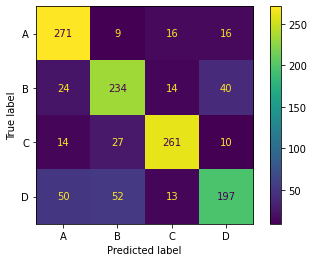

              precision    recall  f1-score   support

           A       0.75      0.87      0.81       312
           B       0.73      0.75      0.74       312
           C       0.86      0.84      0.85       312
           D       0.75      0.63      0.69       312

    accuracy                           0.77      1248
   macro avg       0.77      0.77      0.77      1248
weighted avg       0.77      0.77      0.77      1248



In [80]:
cm = confusion_matrix(val_df['label'], grid_aug_predictions, labels=grid_aug.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_aug.classes_)
disp.plot()
plt.show()

print(classification_report(val_df['label'], grid_aug_predictions))#Output